NameError: name 'X' is not defined

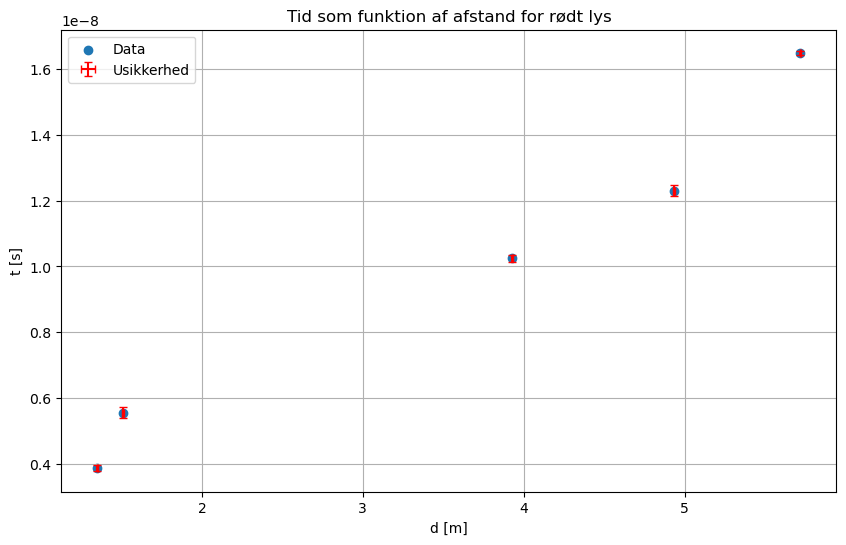

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
from scipy.optimize import curve_fit
from IPython.display import Markdown as md, display_markdown

red_data_loc = r"C:\Users\marcu\OneDrive\Documents\GitHub\MekRelLab\Lab 8 og 11 - lysets hastighed\rødt lys.xlsx"
red_xls = pd.ExcelFile(red_data_loc)

# Indlæs alle ark i excelfilen som numpy arrays
red_data = [np.array(pd.read_excel(red_xls, sheet_name=sheet)) for sheet in red_xls.sheet_names]
# Indlæs hvert ark som en variabel for sig
red_1 = red_data[0]
red_2 = red_data[1]
red_3 = red_data[2]
red_4 = red_data[3]
red_5 = red_data[4]

# Afstandene er værdien i første række af anden søjle i arket (ganget med 2 for at tage højde for afstanden tilbage til sensoren)
# Enhed [m]
red_1_d = red_1[0][1]*2
red_2_d = red_2[0][1]*2
red_3_d = red_3[0][1]*2
red_4_d = red_4[0][1]*2
red_5_d = red_5[0][1]*2

# Tiderne er de første værdier af hver række i arket ganget med 10**(-9) for at få dem i sekunder
# Enhed [s]
red_1_t = red_1[:,0]*10**(-9)
red_2_t = red_2[:,0]*10**(-9)
red_3_t = red_3[:,0]*10**(-9)
red_4_t = red_4[:,0]*10**(-9)
red_5_t = red_5[:,0]*10**(-9)

# En funktion til at beregne lysets gennemsnitlige hastighed ud fra tiderne og afstandene
def c(times, distances):
    return np.mean(distances/times)

# Usikkerhed for tidsmålingerne
# Enhed [s]
t_unc = 0.1*10**(-9)

# Standardafvigelse for tidsmålinger
# Enhed [s]
red_1_t_std = np.std(red_1_t)
red_2_t_std = np.std(red_2_t)
red_3_t_std = np.std(red_3_t)
red_4_t_std = np.std(red_4_t)
red_5_t_std = np.std(red_5_t)

# Usikkerhed for gennemsnit af tidsmålinger
# Enhed [s]
red_1_t_mean_unc = (red_1_t_std/np.sqrt(red_1_t.size))
red_2_t_mean_unc = (red_2_t_std/np.sqrt(red_2_t.size))
red_3_t_mean_unc = (red_3_t_std/np.sqrt(red_3_t.size))
red_4_t_mean_unc = (red_4_t_std/np.sqrt(red_4_t.size))
red_5_t_mean_unc = (red_5_t_std/np.sqrt(red_5_t.size))

# Arrays med afstande og gennemsnitstider

# Tider for rød
# Enhed [m]
red_time_arr = np.array([red_1_t.mean(), red_2_t.mean(), red_3_t.mean(), red_4_t.mean(), red_5_t.mean()])

# Usikkerhed for gennemsnitstider for rød
# Enhed [s]
red_time_unc_arr = np.array([red_1_t_mean_unc, red_2_t_mean_unc, red_3_t_mean_unc, red_4_t_mean_unc, red_5_t_mean_unc])

# Afstande for rød
# Enhed [m]
red_distance_arr = [red_1_d, red_2_d, red_3_d, red_4_d, red_5_d]

# Usikkerhed for afstande for rød
# Enhed [m]
red_d_unc = 0.005

# Lav et scatterplot med afstande på x-aksen og tider på y-aksen
red_plot = plt.figure(figsize=(10, 6))
plt.title("Tid som funktion af afstand for rødt lys")
plt.xlabel("d [m]")
plt.ylabel("t [s]")
plt.scatter(red_distance_arr, red_time_arr, label="Data")
plt.errorbar(red_distance_arr, red_time_arr, xerr=red_d_unc, yerr=red_time_unc_arr, capsize=3, color="red", fmt='none', label="Usikkerhed")
plt.grid()
plt.legend()

# Lav lineær regression med scipy (med usikkerheder)
# Returnerer en tuple med (a, b) hvor a er hældningen og b er skæringen
lin_func = lambda x, a, b: a*x + b
red_par, red_cov = curve_fit(lin_func, red_distance_arr, red_time_arr, sigma=red_time_unc_arr, absolute_sigma=True)

red_lin_sigma = np.sqrt(np.diagonal(red_cov))

red_lin_fit = lambda x: red_par[0]*x + red_par[1]

# Beregn den propagerede usikkerhed fra d til t vha. fittet (se stat. note 2.4)
# Enhed [s]
red_x_to_t_unc = red_par[0]*red_d_unc

# Beregn den samlede usikkerhed for t
red_total_t_unc = red_time_unc_arr + red_x_to_t_unc

# Lav fittet igen med den nye usikkerhed
lin_func = lambda x, a, b: a*x + b
red_par, red_cov = curve_fit(lin_func, red_distance_arr, red_time_arr, sigma=red_total_t_unc, absolute_sigma=True)

red_lin_sigma = np.sqrt(np.diagonal(red_cov))

red_lin_fit = lambda x: red_par[0]*x + red_par[1]

# Tegn fittet i samme plot som scatterplottet
X_red = np.linspace(0, 6, 10000)
Y_red = red_lin_fit(X)

# Inkludér samlet usikkerhed
plt.errorbar(red_distance_arr, red_time_arr, yerr=red_total_t_unc, capsize=3, color="purple", fmt='none', label="Usikkerhed for t inkl. propageret usikkerhed fra d")

plt.plot(X_red, Y_red, color="r", label="Lineær regression")
plt.xlim(0)
plt.legend()

# Gem som png
plt.savefig("red.png", dpi=300)

# Eftersom a = 1/c må c = 1/a
# Vi finder usikkerheden på c vha. ophobningsloven
# Enhed [m/s]
red_c = 1/red_par[0]
red_c_unc = abs(-1/red_par[0]**2)*red_lin_sigma[0]

display_markdown(md(r"Parametrene for det lineære fit: <br> $a = {:e} \pm {:e}$, $b = {:e} \pm {:e}$".format(red_par[0], red_lin_sigma[0], red_par[1], red_lin_sigma[1])))

display_markdown(md(r"Afrundet og med enheder: <br> $a = ({:e} \pm {:e}) \frac{{s}}{{m}}$, $b = ({:e} \pm {:e}) s$".format(round(red_par[0], 11), round(red_lin_sigma[0], 11), round(red_par[1], 10), round(red_lin_sigma[1], 11))))

display_markdown(md(r"Lysets hastighed: <br> $c = \frac{{1}}{{a}} = ({:.2e} \pm {:.0e}) \frac{{m}}{{s}}$".format(red_c, red_c_unc)))



Parametrene for det lineære fit: <br> $a = 2.701073e-09 \pm 4.590787e-11$, $b = -8.778198e-10 \pm 1.761975e-10$

Afrundet og med enheder: <br> $a = (2.70e-09 \pm 5e-11) \frac{s}{m}$, $b = (-9e-10 \pm 2e-10) s$

Lysets hastighed: <br> $c = \frac{1}{a} = (3.70e+08 \pm 6e+06) \frac{m}{s}$

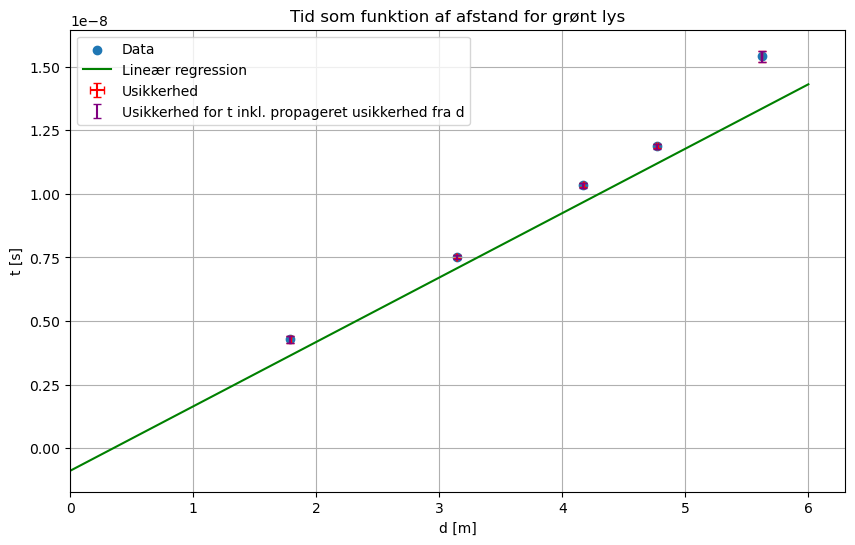

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
from scipy.optimize import curve_fit
from IPython.display import Markdown as md, display_markdown

green_data_loc = r"C:\Users\marcu\OneDrive\Documents\GitHub\MekRelLab\Lab 8 og 11 - lysets hastighed\grønt lys.xlsx"
green_xls = pd.ExcelFile(green_data_loc)

# Indlæs alle ark i excelfilen som numpy arrays
green_data = [np.array(pd.read_excel(green_xls, sheet_name=sheet)) for sheet in green_xls.sheet_names]
# Indlæs hvert ark som en variabel for sig
green_1 = green_data[0]
green_2 = green_data[1]
green_3 = green_data[2]
green_4 = green_data[3]
green_5 = green_data[4]

# Afstandene er værdien i første række af anden søjle i arket (ganget med 2 for at tage højde for afstanden tilbage til sensoren)
# Enhed [m]
green_1_d = green_1[0][1]*2
green_2_d = green_2[0][1]*2
green_3_d = green_3[0][1]*2
green_4_d = green_4[0][1]*2
green_5_d = green_5[0][1]*2

# Tiderne er de første værdier af hver række i arket ganget med 10**(-9) for at få dem i sekunder
# Enhed [s]
green_1_t = green_1[:,0]*10**(-9)
green_2_t = green_2[:,0]*10**(-9)
green_3_t = green_3[:,0]*10**(-9)
green_4_t = green_4[:,0]*10**(-9)
green_5_t = green_5[:,0]*10**(-9)

# En funktion til at beregne lysets gennemsnitlige hastighed ud fra tiderne og afstandene
def c(times, distances):
    return np.mean(distances/times)

# Usikkerhed for tidsmålingerne
# Enhed [s]
t_unc = 0.1*10**(-9)

# Standardafvigelse for tidsmålinger
# Enhed [s]
green_1_t_std = np.std(green_1_t)
green_2_t_std = np.std(green_2_t)
green_3_t_std = np.std(green_3_t)
green_4_t_std = np.std(green_4_t)
green_5_t_std = np.std(green_5_t)

# Usikkerhed for gennemsnit af tidsmålinger
# Enhed [s]
green_1_t_mean_unc = (green_1_t_std/np.sqrt(green_1_t.size))
green_2_t_mean_unc = (green_2_t_std/np.sqrt(green_2_t.size))
green_3_t_mean_unc = (green_3_t_std/np.sqrt(green_3_t.size))
green_4_t_mean_unc = (green_4_t_std/np.sqrt(green_4_t.size))
green_5_t_mean_unc = (green_5_t_std/np.sqrt(green_5_t.size))

# Arrays med afstande og gennemsnitstider

# Tider for rød
# Enhed [m]
green_time_arr = np.array([green_1_t.mean(), green_2_t.mean(), green_3_t.mean(), green_4_t.mean(), green_5_t.mean()])

# Usikkerhed for gennemsnitstider for rød
# Enhed [s]
green_time_unc_arr = np.array([green_1_t_mean_unc, green_2_t_mean_unc, green_3_t_mean_unc, green_4_t_mean_unc, green_5_t_mean_unc])

# Afstande for rød
# Enhed [m]
green_distance_arr = [green_1_d, green_2_d, green_3_d, green_4_d, green_5_d]

# Usikkerhed for afstande for rød
# Enhed [m]
green_d_unc = 0.005

# Lav et scatterplot med afstande på x-aksen og tider på y-aksen
green_plot = plt.figure(figsize=(10, 6))
plt.title("Tid som funktion af afstand for grønt lys")
plt.xlabel("d [m]")
plt.ylabel("t [s]")
plt.scatter(green_distance_arr, green_time_arr, label="Data")
plt.errorbar(green_distance_arr, green_time_arr, xerr=green_d_unc, yerr=green_time_unc_arr, capsize=3, color="r", fmt='none', label="Usikkerhed")
plt.grid()
plt.legend()

# Lav lineær regression med scipy (med usikkerheder)
# Returnerer en tuple med (a, b) hvor a er hældningen og b er skæringen
lin_func = lambda x, a, b: a*x + b
green_par, green_cov = curve_fit(lin_func, green_distance_arr, green_time_arr, sigma=green_time_unc_arr, absolute_sigma=True)

green_lin_sigma = np.sqrt(np.diagonal(green_cov))

green_lin_fit = lambda x: green_par[0]*x + green_par[1]

# Beregn den propagegreene usikkerhed fra d til t vha. fittet (se stat. note 2.4)
# Enhed [s]
green_x_to_t_unc = green_par[0]*green_d_unc

# Beregn den samlede usikkerhed for t
green_total_t_unc = green_time_unc_arr + green_x_to_t_unc

# Lav fittet igen med den nye usikkerhed
lin_func = lambda x, a, b: a*x + b
green_par, green_cov = curve_fit(lin_func, green_distance_arr, green_time_arr, sigma=green_total_t_unc, absolute_sigma=True)

green_lin_sigma = np.sqrt(np.diagonal(green_cov))

green_lin_fit = lambda x: green_par[0]*x + green_par[1]

# Tegn fittet i samme plot som scatterplottet
X_green = np.linspace(0, 6, 10000)
Y_green = green_lin_fit(X)

# Inkludér samlet usikkerhed
plt.errorbar(green_distance_arr, green_time_arr, yerr=green_total_t_unc, capsize=3, color="purple", fmt='none', label="Usikkerhed for t inkl. propageret usikkerhed fra d")

plt.plot(X_green, Y_green, color="g", label="Lineær regression")
plt.xlim(0)
plt.legend()

# Gem som png
plt.savefig("green.png", dpi=300)

# Eftersom a = 1/c må c = 1/a
# Vi finder usikkerheden på c vha. ophobningsloven
# Enhed [m/s]
green_c = 1/green_par[0]
green_c_unc = abs(-1/green_par[0]**2)*green_lin_sigma[0]

display_markdown(md(r"Parametrene for det lineære fit: <br> $a = {:e} \pm {:e}$, $b = {:e} \pm {:e}$".format(green_par[0], green_lin_sigma[0], green_par[1], green_lin_sigma[1])))

display_markdown(md(r"Afrundet og med enheder: <br> $a = ({:.2e} \pm {:.0e}) \frac{{s}}{{m}}$, $b = ({:.0e} \pm {:.0e}) s$".format(green_par[0], green_lin_sigma[0], green_par[1], green_lin_sigma[1])))

display_markdown(md(r"Lysets hastighed: <br> $c = \frac{{1}}{{a}} = ({:.2e} \pm {:.0e}) \frac{{m}}{{s}}$".format(green_c, green_c_unc)))



Parametrene for det lineære fit: <br> $a = 2.189242e-09 \pm 4.891018e-11$, $b = 1.849267e-09 \pm 1.438395e-10$

Afrundet og med enheder: <br> $a = (2.19e-09 \pm 5e-11) \frac{s}{m}$, $b = (1.8e-09 \pm 1e-10) s$

Lysets hastighed: <br> $c = \frac{1}{a} = (4.6e+08 \pm 1e+07) \frac{m}{s}$

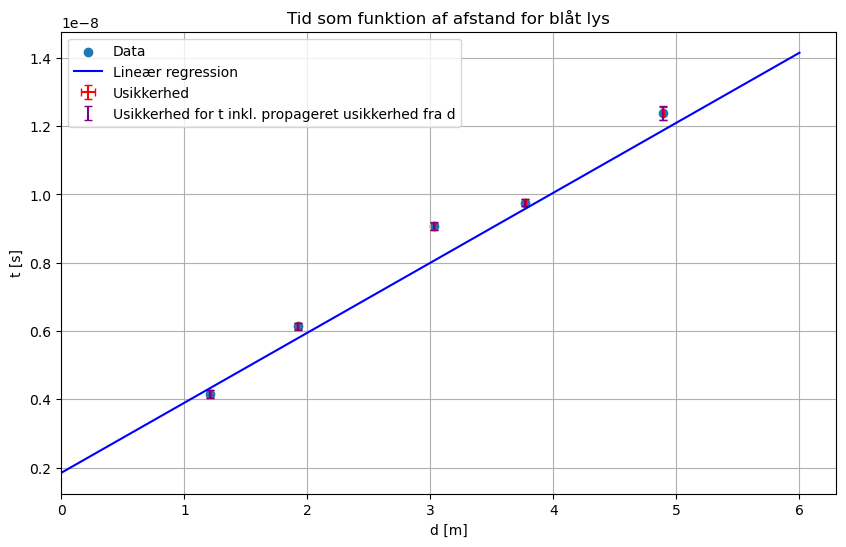

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
from scipy.optimize import curve_fit
from IPython.display import Markdown as md, display_markdown

blue_data_loc = r"C:\Users\marcu\OneDrive\Documents\GitHub\MekRelLab\Lab 8 og 11 - lysets hastighed\blåt lys.xlsx"
blue_xls = pd.ExcelFile(blue_data_loc)

# Indlæs alle ark i excelfilen som numpy arrays
blue_data = [np.array(pd.read_excel(blue_xls, sheet_name=sheet)) for sheet in blue_xls.sheet_names]
# Indlæs hvert ark som en variabel for sig
blue_1 = blue_data[0]
blue_2 = blue_data[1]
blue_3 = blue_data[2]
blue_4 = blue_data[3]
blue_5 = blue_data[4]

# Afstandene er værdien i første række af anden søjle i arket (ganget med 2 for at tage højde for afstanden tilbage til sensoren)
# Enhed [m]
blue_1_d = blue_1[0][1]*2
blue_2_d = blue_2[0][1]*2
blue_3_d = blue_3[0][1]*2
blue_4_d = blue_4[0][1]*2
blue_5_d = blue_5[0][1]*2

# Tiderne er de første værdier af hver række i arket ganget med 10**(-9) for at få dem i sekunder
# Enhed [s]
blue_1_t = blue_1[:,0]*10**(-9)
blue_2_t = blue_2[:,0]*10**(-9)
blue_3_t = blue_3[:,0]*10**(-9)
blue_4_t = blue_4[:,0]*10**(-9)
blue_5_t = blue_5[:,0]*10**(-9)

# En funktion til at beregne lysets gennemsnitlige hastighed ud fra tiderne og afstandene
def c(times, distances):
    return np.mean(distances/times)

# Usikkerhed for tidsmålingerne
# Enhed [s]
t_unc = 0.1*10**(-9)

# Standardafvigelse for tidsmålinger
# Enhed [s]
blue_1_t_std = np.std(blue_1_t)
blue_2_t_std = np.std(blue_2_t)
blue_3_t_std = np.std(blue_3_t)
blue_4_t_std = np.std(blue_4_t)
blue_5_t_std = np.std(blue_5_t)

# Usikkerhed for gennemsnit af tidsmålinger
# Enhed [s]
blue_1_t_mean_unc = (blue_1_t_std/np.sqrt(blue_1_t.size))
blue_2_t_mean_unc = (blue_2_t_std/np.sqrt(blue_2_t.size))
blue_3_t_mean_unc = (blue_3_t_std/np.sqrt(blue_3_t.size))
blue_4_t_mean_unc = (blue_4_t_std/np.sqrt(blue_4_t.size))
blue_5_t_mean_unc = (blue_5_t_std/np.sqrt(blue_5_t.size))

# Arrays med afstande og gennemsnitstider

# Tider for rød
# Enhed [m]
blue_time_arr = np.array([blue_1_t.mean(), blue_2_t.mean(), blue_3_t.mean(), blue_4_t.mean(), blue_5_t.mean()])

# Usikkerhed for gennemsnitstider for rød
# Enhed [s]
blue_time_unc_arr = np.array([blue_1_t_mean_unc, blue_2_t_mean_unc, blue_3_t_mean_unc, blue_4_t_mean_unc, blue_5_t_mean_unc])

# Afstande for rød
# Enhed [m]
blue_distance_arr = [blue_1_d, blue_2_d, blue_3_d, blue_4_d, blue_5_d]

# Usikkerhed for afstande for rød
# Enhed [m]
blue_d_unc = 0.005

# Lav et scatterplot med afstande på x-aksen og tider på y-aksen
blue_plot = plt.figure(figsize=(10, 6))
plt.title("Tid som funktion af afstand for blåt lys")
plt.xlabel("d [m]")
plt.ylabel("t [s]")
plt.scatter(blue_distance_arr, blue_time_arr, label="Data")
plt.errorbar(blue_distance_arr, blue_time_arr, xerr=blue_d_unc, yerr=blue_time_unc_arr, capsize=3, color="r", fmt='none', label="Usikkerhed")
plt.grid()
plt.legend()

# Lav lineær regression med scipy (med usikkerheder)
# Returnerer en tuple med (a, b) hvor a er hældningen og b er skæringen
lin_func = lambda x, a, b: a*x + b
blue_par, blue_cov = curve_fit(lin_func, blue_distance_arr, blue_time_arr, sigma=blue_time_unc_arr, absolute_sigma=True)

blue_lin_sigma = np.sqrt(np.diagonal(blue_cov))

blue_lin_fit = lambda x: blue_par[0]*x + blue_par[1]

# Beregn den propagebluee usikkerhed fra d til t vha. fittet (se stat. note 2.4)
# Enhed [s]
blue_x_to_t_unc = blue_par[0]*blue_d_unc

# Beregn den samlede usikkerhed for t
blue_total_t_unc = blue_time_unc_arr + blue_x_to_t_unc

# Lav fittet igen med den nye usikkerhed
lin_func = lambda x, a, b: a*x + b
blue_par, blue_cov = curve_fit(lin_func, blue_distance_arr, blue_time_arr, sigma=blue_total_t_unc, absolute_sigma=True)

blue_lin_sigma = np.sqrt(np.diagonal(blue_cov))

blue_lin_fit = lambda x: blue_par[0]*x + blue_par[1]

# Tegn fittet i samme plot som scatterplottet
X_blue = np.linspace(0, 6, 10000)
Y_blue = blue_lin_fit(X)

# Inkludér samlet usikkerhed
plt.errorbar(blue_distance_arr, blue_time_arr, yerr=blue_total_t_unc, capsize=3, color="purple", fmt='none', label="Usikkerhed for t inkl. propageret usikkerhed fra d")

plt.plot(X_blue, Y_blue, color="b", label="Lineær regression")
plt.xlim(0)
plt.legend()

# Gem som png
plt.savefig("blue.png", dpi=300)

# Eftersom a = 1/c må c = 1/a
# Vi finder usikkerheden på c vha. ophobningsloven
# Enhed [m/s]
blue_c = 1/blue_par[0]
blue_c_unc = abs(-1/blue_par[0]**2)*blue_lin_sigma[0]

display_markdown(md(r"Parametrene for det lineære fit: <br> $a = {:e} \pm {:e}$, $b = {:e} \pm {:e}$".format(blue_par[0], blue_lin_sigma[0], blue_par[1], blue_lin_sigma[1])))

display_markdown(md(r"Afrundet og med enheder: <br> $a = ({:.2e} \pm {:.0e}) \frac{{s}}{{m}}$, $b = ({:.1e} \pm {:.0e}) s$".format(blue_par[0], blue_lin_sigma[0], blue_par[1], blue_lin_sigma[1])))

display_markdown(md(r"Lysets hastighed: <br> $c = \frac{{1}}{{a}} = ({:.1e} \pm {:.0e}) \frac{{m}}{{s}}$".format(blue_c, blue_c_unc)))





In [8]:
# RØD

X = np.linspace(0, 6, 10000)
Y = green_lin_fit(X)

plt.figure(figsize=(10, 6))
plt.title("Tid som funktion af afstand for lys af forskellige farver (farven af punkter/regressionslinje svarer til farven på lyset)")
plt.xlabel("Afstand [m]")
plt.ylabel("Tid [s]")
plt.scatter(red_distance_arr, red_time_arr, color="red", label="Data")
plt.errorbar(red_distance_arr, red_time_arr, xerr=red_d_unc, yerr=red_time_unc_arr, capsize=3, color="black", fmt='none', label="Usikkerhed")
plt.grid()
plt.legend()

# Inkludér samlet usikkerhed
plt.errorbar(red_distance_arr, red_time_arr, yerr=red_total_t_unc, capsize=3, color="purple", fmt='none', label="Usikkerhed for t inkl. propageret usikkerhed fra d")

plt.plot(X, Y, color="r", label="Lineær regression")
plt.xlim(0)
plt.legend()

# GRØN

# Lav et scatterplot med afstande på x-aksen og tider på y-aksen
plt.scatter(green_distance_arr, green_time_arr, color="green", label="Data")
plt.errorbar(green_distance_arr, green_time_arr, xerr=green_d_unc, yerr=green_time_unc_arr, capsize=3, color="black", fmt='none')
plt.grid()
plt.legend()

# Inkludér samlet usikkerhed
plt.errorbar(green_distance_arr, green_time_arr, yerr=green_total_t_unc, capsize=3, color="purple", fmt='none')

plt.plot(X, Y, color="g", label="Lineær regression")
plt.xlim(0)
plt.legend()

# BLÅ

# Lav et scatterplot med afstande på x-aksen og tider på y-aksen
plt.scatter(blue_distance_arr, blue_time_arr, color="blue", label="Data")
plt.errorbar(blue_distance_arr, blue_time_arr, xerr=blue_d_unc, yerr=blue_time_unc_arr, capsize=3, color="black", fmt='none')
plt.grid()
plt.legend()

# Inkludér samlet usikkerhed
plt.errorbar(blue_distance_arr, blue_time_arr, yerr=blue_total_t_unc, capsize=3, color="purple", fmt='none')

plt.plot(X, Y, color="b", label="Lineær regression")
plt.xlim(0)
plt.legend()

# Gem som png
plt.savefig("all.png", dpi=300)



NameError: name 'green_lin_fit' is not defined